In [49]:
from methods import *
from L_calc import *

import pandas as pd
import matplotlib.pyplot as plt

In [50]:
from models.LeNet import *
mnist = LeNet("models/lenet_mnist_model.pth")
mnist_model = target_lenet.model
mnist_device = target_lenet.device
mnist_test_loader = target_lenet.testloader

from models.simple_FashionMNIST import *
fmnist = simple_FashionMNIST("models/simple_FashionMNIST.pth")
fmnist_model = fmnist.model
fmnist_device = fmnist.device
fmnist_test_loader = fmnist.testloader

from models.resNet import ResNet20
cifar = ResNet20()
cifar10 = cifar.model
cifar10device = cifar.device
cifar10test_loader = cifar.testloader

# L_constants [6.701272487640381, 19.250612258911133, 3.085362672805786]

Running on cpu.
Model weights loaded successfully


Using cache found in C:\Users\alepa/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [51]:
fw_iters = [15]
eps = 0.03
hist = None
debug = True
# Run test for each epsilon

all_algos = ['fsgm', 'pgd', 
             'fw', 'fw_momentum', 'fw_l1', 'fw_l2', 'fw_p2', 
             'fw_away', 'fw_away_l1', 'fw_away_l2', 'fw_away_p2',
             'fw_pair', 'fw_pair_l1', 'fw_pair_l2', 'fw_pair_p2']

all_stepsizes = ['fixed', 'decay', 'ls'] # fix armijo and add it

In [52]:
def history(test_fw, dataset, device, eps, iterations, method='fw_pair', early_stopping='gap_FW', fw_stepsize_rule='fixed', gap_FW_tol=0.1):
    accuracies = []
    examples = []
    all_hist = []
    final_hist_dfs = []
    epsilons = [0.001, 0.005, 0.01, 0.05, 0.1]

    for eps in epsilons:
        # Run the test function with the given parameters
        acc, ex, hist = test_fw(dataset, device, eps, iterations, method=method, early_stopping=early_stopping, fw_stepsize_rule=fw_stepsize_rule, gap_FW_tol=gap_FW_tol)
        
        # Collect the results
        accuracies.append(acc)
        examples.append(ex)
        all_hist.append(hist)
        
        # Group by 'example_idx' and get the last row for each group
        final_hist = hist.groupby('example_idx').tail(1)
        final_hist_dfs.append(final_hist)

    # Combine all historical dataframes into one
    hist_df = pd.concat(all_hist).reset_index(drop=True)
    final_hist_df = pd.concat(final_hist_dfs).reset_index(drop=True)
    
    # Display the historical dataframes
    display(hist_df)

    # Plot the accuracy per epsilon
    plt.figure(figsize=(10, 6))
    plt.plot(epsilons, accuracies, marker='o')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epsilon')
    plt.grid(True)
    plt.show()

Epsilon: 0.001	Correct Classifications (Failed Attacks) = 992 / 1000 = 0.992
Epsilon: 0.005	Correct Classifications (Failed Attacks) = 988 / 1000 = 0.988
Epsilon: 0.01	Correct Classifications (Failed Attacks) = 991 / 1000 = 0.991
Epsilon: 0.05	Correct Classifications (Failed Attacks) = 960 / 1000 = 0.96
Epsilon: 0.1	Correct Classifications (Failed Attacks) = 790 / 1000 = 0.79


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS,step_type,max_step,stepsize,alphas,diff,drop_step
0,0,1,0.071104,False,False,9,9,None,0.000000,FW,1,1,[1],0.002,FW
1,0,2,0.030351,False,False,9,9,None,-0.030044,FW,1,1,[1],0.004,FW
2,0,3,0.030451,False,False,9,9,None,-0.030316,FW,1,1,[1],0.004,FW
3,0,4,0.030613,False,False,9,9,None,-0.030374,FW,1,1,[1],0.004,FW
4,0,5,0.030532,False,False,9,9,None,-0.030379,FW,1,1,[1],0.004,FW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74470,999,11,0.487629,True,False,4,2,None,-0.220340,FW,1,1,[1],0.400,FW
74471,999,12,0.180447,True,False,4,2,None,-0.089530,FW,1,1,[1],0.400,FW
74472,999,13,0.453428,True,False,4,2,None,-0.195879,FW,1,1,[1],0.400,FW
74473,999,14,0.350784,True,False,4,2,None,-0.154466,FW,1,1,[1],0.400,FW


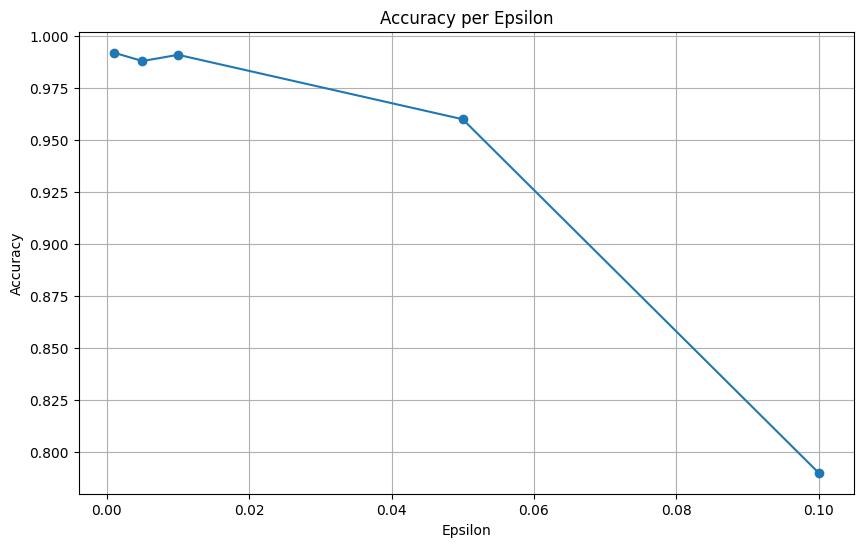

In [53]:
history(test_fw, mnist, mnist_device, eps, 15, method='fw_away', early_stopping='gap_AS', fw_stepsize_rule='fixed', gap_FW_tol=0.1)